In [48]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as ss
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
UIMatrix = np.load('UIMatrix.npy')
# UIMatrix = ss.csr_matrix(UIMatrix)
UIMatrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2. , 0.5, 0. , ..., 0. , 2. , 0. ],
       [0. , 3. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [4]:
row, col, val = ss.find(UIMatrix)
print(row.shape)

(27743,)


20889.23597656067
9813.979221134026
9728.942399387826
9702.684714293844
9691.319950702818
9685.3435398437
9681.756856148799
训练时间： 1790.143373966217
[9680.813511840859, 9680.80850286435, 9680.803497580739, 9680.79849598554, 9680.793498074656]
3181


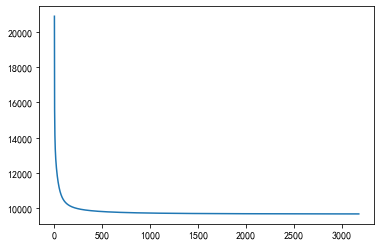

In [17]:
# 逐元素
X = UIMatrix.copy()

def train(loss, lam, k):
    n, m = X.shape
    row, col, val = ss.find(X)

    step = 8e-3
    eps = 5e-3

    # 划分训练集，验证集，测试集
    ziprc = np.array((row, col, val)).T
    np.random.shuffle(ziprc)
    test_size = int(0.18 * ziprc.shape[0])
    validation_size = int(0.18 * ziprc.shape[0])
    test = ziprc[:test_size, :]
    validation = ziprc[test_size:test_size+validation_size, :]
    train = ziprc[test_size+validation_size:, :]

    # 初始化
    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵

    train_x = list(train[:, 0].astype(int))
    train_y = list(train[:, 1].astype(int))

    max_iter = int(5e4)
    lossi_old = 1e6
    start_t = time.time()
    for _ in range(max_iter):
        lossi = 0
        for i, j in zip(train_x, train_y):
            pi = P[i, :]
            qj = Q[:, j]
            eij = X[i, j] - np.dot(pi, qj)
            pi += step * (eij * qj - lam * pi)
            qj += step * (eij * pi - lam * qj)
            lossi += (eij**2 + lam*(np.dot(pi,pi)+np.dot(qj,qj)))
        lossi *= 0.5
        loss.append(lossi)
        if np.abs(lossi - lossi_old) < eps:
            break
        lossi_old = lossi
        if _ % 500 == 0:
            print(lossi)
    print("训练时间：", time.time()-start_t)
    return P, Q, validation, test


loss = []
lam = 0.1 # 正则化系数
k = 18  # 隐空间大小
P, Q, validation, test = train(loss, lam, k)
print(loss[-5:])  # 观察最后loss值
print(len(loss))  # 打印迭代次数
plt.plot(range(len(loss)), loss)
plt.show()

# np.save('全批量，无正则化，固定步长loss', np.array(loss))
# np.save('全批量，无正则化，固定步长P', P)
# np.save('全批量，无正则化，固定步长Q', Q)
# np.save('全批量，无正则化，测试集', test)
# np.save('全批量，无正则化，验证集', validation)

In [18]:
# 验证集RMSE
validation_x = list(validation[:, 0].astype(int))
validation_y = list(validation[:, 1].astype(int))
loss = 0
for i, j in zip(validation_x, validation_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(pi@qj)
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2 + lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
print(np.sqrt(loss/len(validation_x)))

r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 2.5  r_ij_hat: 3.0  loss: -0.5
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 2.0  r_ij_hat: 2.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 1.0  r_ij_hat: 2.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 2.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 2.0  loss: 1.0
r_ij: 1.0  r_ij_hat: 1.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 3.5  r_ij_hat: 2.0  loss: 1.5
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.

In [19]:
# 测试集 RMSE、MAE
test_x = list(test[:, 0].astype(int))
test_y = list(test[:, 1].astype(int))
loss = 0
mae = 0
for i, j in zip(test_x, test_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(P[i, :].T @ Q[:, j])
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2+ lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
    mae += np.abs(lossi)
print(np.sqrt(loss/len(test_x)))
print("MAE:", mae/len(test_x))

r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 2.0  loss: 3.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 2.5  r_ij_hat: 2.0  loss: 0.5
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 4.0  l

In [84]:
index = np.argsort(P[3,:]@Q)[::-1]
map = np.load("movie_map.npy").astype(int)
movies = pd.read_csv('ml-latest-small/movies.csv')
print("用户4可能最偏好的电影：")
for i in range(15):
    idx = index[i]
    try:
        id = map[map[:,1]==idx][0][0]
        print("电影：", id, list(movies[movies['movieId']==id]['title']),list(movies[movies['movieId']==id]['genres']))
    except:
        pass

用户4可能最偏好的电影：
电影： 1040 ['Secret Agent, The (1996)'] ['Drama']
电影： 893 ['Mother Night (1996)'] ['Drama']
电影： 3577 ['Two Moon Junction (1988)'] ['Drama|Romance']
电影： 2154 ['How Stella Got Her Groove Back (1998)'] ['Drama|Romance']
电影： 2007 ['Polish Wedding (1998)'] ['Comedy']
电影： 3569 ['Idiots, The (Idioterne) (1998)'] ['Comedy|Drama']
电影： 2984 ['On Any Sunday (1971)'] ['Documentary']
电影： 3469 ['Inherit the Wind (1960)'] ['Drama']
电影： 973 ['Meet John Doe (1941)'] ['Comedy|Drama']
电影： 2926 ['Hairspray (1988)'] ['Comedy|Drama']
电影： 1449 ['Waiting for Guffman (1996)'] ['Comedy']
电影： 2204 ['Saboteur (1942)'] ['Mystery|Thriller']
电影： 2298 ['Strangeland (1998)'] ['Thriller']
电影： 2965 ['Omega Code, The (1999)'] ['Action']
电影： 3442 ['Band of the Hand (1986)'] ['Action|Crime|Drama']


In [81]:
usr4 = UIMatrix[3,:]
for i in range(len(usr4)):
    if usr4[i] == 5:
        try:
            id = map[map[:,1]==i][0][0]
            print("电影：", id, list(movies[movies['movieId']==id]['title']),list(movies[movies['movieId']==id]['genres']))
        except:
            pass

电影： 125 ['Flirting With Disaster (1996)'] ['Comedy']
电影： 162 ['Crumb (1994)'] ['Documentary']
电影： 176 ['Living in Oblivion (1995)'] ['Comedy']
电影： 215 ['Before Sunrise (1995)'] ['Drama|Romance']
电影： 232 ['Eat Drink Man Woman (Yin shi nan nu) (1994)'] ['Comedy|Drama|Romance']
电影： 260 ['Star Wars: Episode IV - A New Hope (1977)'] ['Action|Adventure|Sci-Fi']
电影： 265 ['Like Water for Chocolate (Como agua para chocolate) (1992)'] ['Drama|Fantasy|Romance']
电影： 319 ['Shallow Grave (1994)'] ['Comedy|Drama|Thriller']
电影： 342 ["Muriel's Wedding (1994)"] ['Comedy']
电影： 457 ['Fugitive, The (1993)'] ['Thriller']
电影： 475 ['In the Name of the Father (1993)'] ['Drama']
电影： 492 ['Manhattan Murder Mystery (1993)'] ['Comedy|Mystery']
电影： 538 ['Six Degrees of Separation (1993)'] ['Drama']
电影： 593 ['Silence of the Lambs, The (1991)'] ['Crime|Horror|Thriller']
电影： 608 ['Fargo (1996)'] ['Comedy|Crime|Drama|Thriller']
电影： 898 ['Philadelphia Story, The (1940)'] ['Comedy|Drama|Romance']
电影： 908 ['North by North